<a href="https://colab.research.google.com/github/Arijit-datascience/CIFAR10_Image_Recognition/blob/main/CIFAR10_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Advanced Convolutions

A. Target

change the code such that it uses GPU
change the architecture to C1C2C3C40 (basically 3 MPs)
total RF must be more than 44
one of the layers must use Depthwise Separable Convolution
one of the layers must use Dilated Convolution
use GAP (compulsory):- add FC after GAP to target #of classes (optional)
achieve 80% accuracy, as many epochs as you want. Total Params to be less than 1M.
B. Results

Parameters: 815,200
Best Training Accuracy in 20 epochs: 87.72%
Best Test Accuracy in 20 epochs: 85.09 %
Total RF reached: 76*76 at the end of Conv block 4
C. Analysis

Model meets all the mentioned targets. I have used the Depthwise seprable con and dialted kernel in the conv block 3. Also, As train test gap was coming more in earlier versions, I have used the horizontal flip and random rotations to act as regulaizer and reduce the train test gap. Code is modularized and uploaded as package in git repo.

In [ ]:
import torch
import torch.optim as optim

from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, OneCycleLR

In [ ]:
!git clone https://github.com/Arijit-datascience/CIFAR10_Image_Recognition

Cloning into 'CIFAR10_Image_Recognition'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 160 (delta 77), reused 103 (delta 38), pack-reused 0
Receiving objects: 100% (160/160), 629.35 KiB | 14.64 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 30.9MB/s 
     |████████████████████████████████| 952kB 38.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=ad9218721aeb04a6ffdbe28482050de8df355ba20327fafc8b17020999254bd0
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
from CIFAR10_Image_Recognition.dataset import dataset as dataset
from CIFAR10_Image_Recognition.models import model as models
from CIFAR10_Image_Recognition.models import train as train
from CIFAR10_Image_Recognition.models import test as test
from CIFAR10_Image_Recognition.plots_accuracy import plots as utils

In [ ]:
norm_mean,norm_std = dataset.cifar10_mean_std()


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_transform, test_transform = dataset.get_transforms(norm_mean,norm_std)

(0.49, 0.48, 0.45) (0.25, 0.24, 0.26)


In [ ]:
# Extract and transform the data
train_set,test_set = dataset.get_datasets(train_transform,test_transform)

# Targets -> ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = train_set.classes

# Dataloader Arguments & Test/Train Dataloaders - Load part of ETL
train_loader,test_loader = dataset.get_dataloaders(train_set,test_set)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


## Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying 10 images


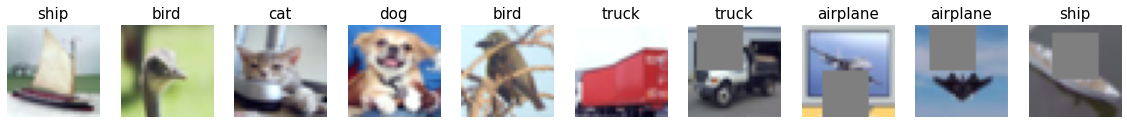

In [ ]:
# Explore sample images
utils.show_sample_images(train_loader, classes, .5, .25, num_of_images = 10)

## Import Model and show model summary

In [ ]:
# Model summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,864
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]             576
             ReLU-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 32, 16, 16]           2,080
           Conv2d-14           [-1

## Train and Test

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=20,steps_per_epoch=len(train_loader))

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train.train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test.test(model, device, test_loader, test_losses, test_acc)

EPOCH: 1

Train set: Average loss: 1.7606, Train Accuracy: 13157/50000 (26.31%)


Test set: Average loss: 1.6191, Test Accuracy: 3920/10000 (39.20%)

EPOCH: 2

Train set: Average loss: 1.5664, Train Accuracy: 20617/50000 (41.23%)


Test set: Average loss: 1.3878, Test Accuracy: 4858/10000 (48.58%)

EPOCH: 3

Train set: Average loss: 1.5767, Train Accuracy: 23973/50000 (47.95%)


Test set: Average loss: 1.2348, Test Accuracy: 5483/10000 (54.83%)

EPOCH: 4

Train set: Average loss: 1.3092, Train Accuracy: 26440/50000 (52.88%)


Test set: Average loss: 1.1402, Test Accuracy: 5827/10000 (58.27%)

EPOCH: 5

Train set: Average loss: 1.1788, Train Accuracy: 28175/50000 (56.35%)


Test set: Average loss: 1.0513, Test Accuracy: 6177/10000 (61.77%)

EPOCH: 6

Train set: Average loss: 1.2228, Train Accuracy: 29533/50000 (59.07%)


Test set: Average loss: 1.0070, Test Accuracy: 6391/10000 (63.91%)

EPOCH: 7

Train set: Average loss: 0.9063, Train Accuracy: 30806/50000 (61.61%)


Test set: Average 

## Validation accuracy and Loss curves

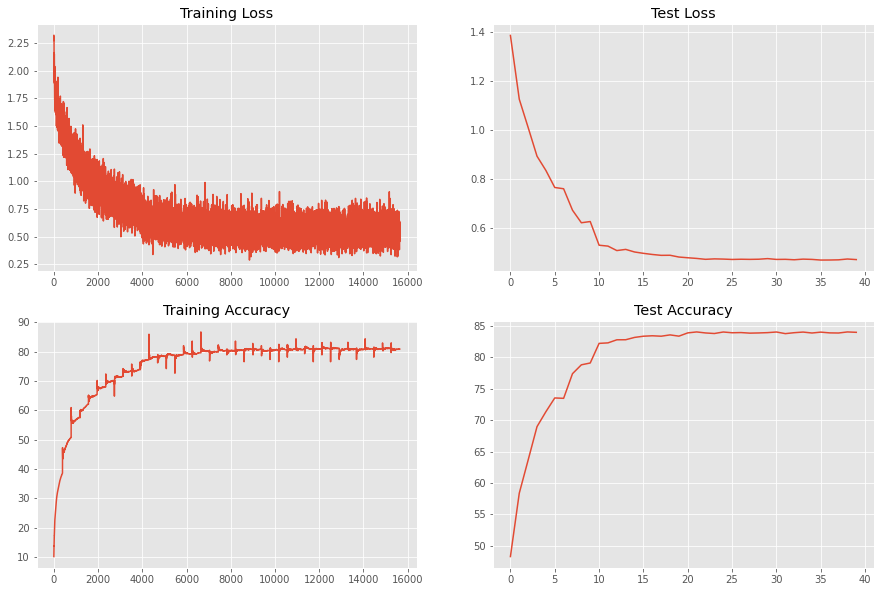

In [ ]:
utils.valid_accuracy_loss_plots(train_losses, train_acc, test_losses, test_acc)

## Display misclassified images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

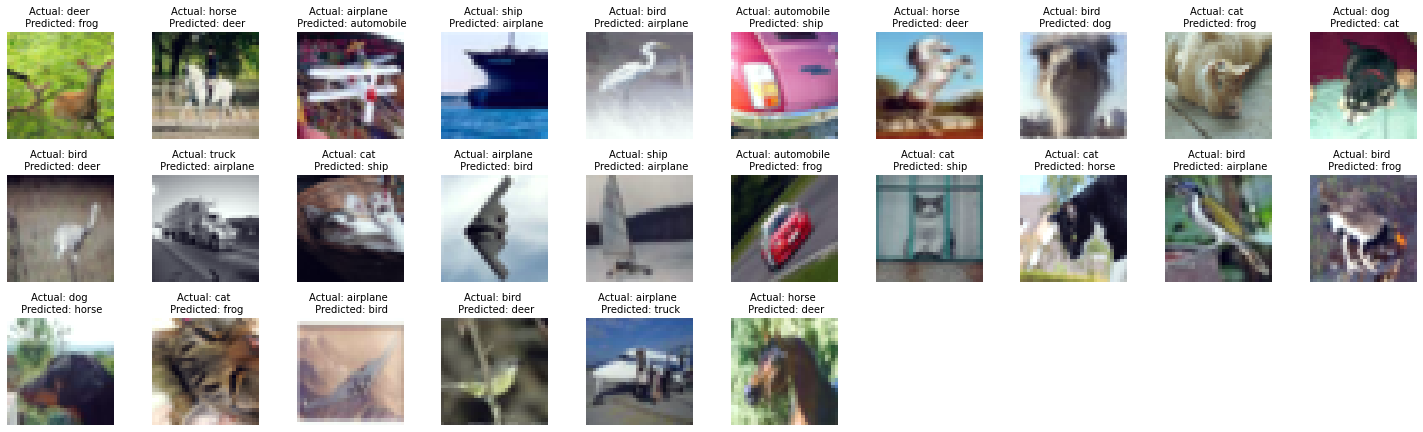

In [ ]:
utils.show_misclassified_images(model, classes, test_loader, num_of_images = 25)